In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from pprint import pprint
from sklearn.datasets import load_digits

In [2]:
np.set_printoptions(suppress=True)

In [3]:
mnist_small = load_digits()
print("MNIST dataset loaded.")

MNIST dataset loaded.


In [4]:
pprint(mnist_small);

{'DESCR': '.. _digits_dataset:\n'
          '\n'
          'Optical recognition of handwritten digits dataset\n'
          '--------------------------------------------------\n'
          '\n'
          '**Data Set Characteristics:**\n'
          '\n'
          '    :Number of Instances: 1797\n'
          '    :Number of Attributes: 64\n'
          '    :Attribute Information: 8x8 image of integer pixels in the '
          'range 0..16.\n'
          '    :Missing Attribute Values: None\n'
          "    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)\n"
          '    :Date: July; 1998\n'
          '\n'
          'This is a copy of the test set of the UCI ML hand-written digits '
          'datasets\n'
          'https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits\n'
          '\n'
          'The data set contains images of hand-written digits: 10 classes '
          'where\n'
          'each class refers to a digit.\n'
          '\n'
          'Preproces

In [5]:
# Each image is a 8x8 image
print("Shape of MNIST", mnist_small["data"].shape)

Shape of MNIST (1797, 64)


Target: 1


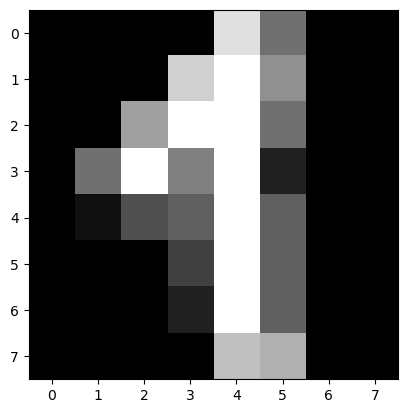

In [6]:
index = 70

digit = mnist_small["data"][index].reshape(8, 8)
plt.imshow(digit, cmap = "gray");

print("Target:", mnist_small["target"][index])

## Feature engineering [Standardscaler]

In [7]:
class StandardScaler:
    def __init__(self, mean = None, standard_dev = None, eps = 0.00001):
        self.mean = mean
        self.eps = eps
        self.standard_dev = standard_dev
    
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.standard_dev = np.std(X, axis=0) + self.eps
    
    def fit_transform(self, X):
        self.fit(X)
        return (X - self.mean) / self.standard_dev
    
    def transform(self, X):
        if self.mean is None and self.standard_dev is None:
            raise ValueError("fit method must be called before transform")
        return (X - self.mean) / self.standard_dev

In [8]:
X = mnist_small["data"]

In [9]:
scaler = StandardScaler()
scaler.fit(X)

In [10]:
# Scaling the features
X_scaled = scaler.transform(X)
assert X_scaled.shape == X.shape

## Principle Component Analysis

In [18]:
class PrincipleComponentAnalysis:
    def __init__(self, n_components = 2):
        self.n_components = n_components        
        self.covar = None
        self.eigenvalues, self.eigenvectors = None, None
        self.preserved_variances = None
        self.transformed_X = None
        
    def fit(self, X):
        # Assuming X to be standarized, shape: [n_rows, n_features]
        # computing covariance matrix
        n = X.shape[0]
        self.covar = np.dot(X.T, X) * (1 / n)
        assert self.covar.shape[0] == self.covar.shape[1] == X.shape[1]
        
        # Computing eigen values and eigen vectors
        self.eigenvalues, self.eigenvectors = np.linalg.eig(self.covar)
        
        # computing the cumulative sum of eigen values
        # represents variance on each eigen vector
        variances = np.cumsum(self.eigenvalues) / np.sum(self.eigenvalues)
        sorted_indices = np.argsort(variances)
        self.preserved_variances = variances[sorted_indices]
        
        # sorting the eigen values and eigen vectors
        self.eigenvalues = self.eigenvalues[sorted_indices]
        self.eigenvectors = self.eigenvectors[sorted_indices]
        
        
        # projecting the original dataset on the eigen vectors
        self.transformed_X = np.dot(X, self.eigenvectors[:, :self.n_components])
        
    def transform(self, X):
        return self.transformed_X
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transformed_X

In [19]:
pca = PrincipleComponentAnalysis(n_components = 2)
pca.fit(X_scaled)

In [20]:
X_transformed = pca.transform(X_scaled)
print("Shape of transformed dataset:", X_transformed.shape)

Shape of transformed dataset: (1797, 2)


In [23]:
data = {
    "x" : X_transformed[:, 0],
    "y" : X_transformed[:, 1],
    "class" : mnist_small["target"].tolist()
}

df = pd.DataFrame(data)

In [24]:
df.head(5)

,x,y,class
0,-1.914210,0.954519,0
1,-0.588985,-0.924672,1
2,-1.302045,0.317154,2
3,3.020772,0.868792,3
4,-4.528959,1.093445,4


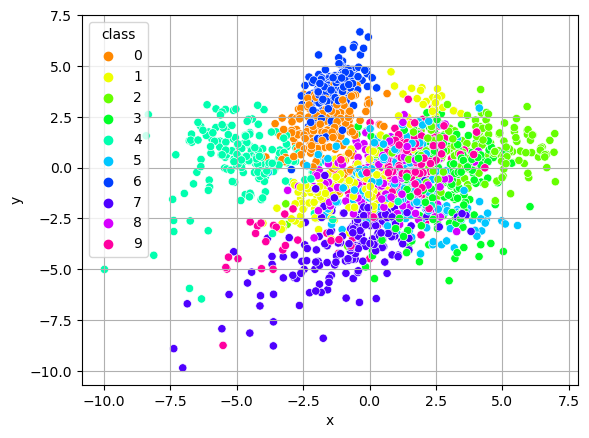

In [28]:
palette = sns.color_palette("hsv", len(df['class'].unique()))
sns.scatterplot(x='x', y='y', hue='class', palette=palette, data=df)

plt.show()

In [39]:
pca = PrincipleComponentAnalysis(n_components = 3)
pca.fit(X_scaled)

X_transformed = pca.transform(X_scaled)
print("Shape of transformed dataset:", X_transformed.shape)

data = {
    "x" : X_transformed[:, 0],
    "y" : X_transformed[:, 1],
    "z" : X_transformed[:, 2],
    "class" : mnist_small["target"].tolist()
}

df = pd.DataFrame(data)

fig = px.scatter_3d(df, x='x', y='y', z='z', color='class')
fig.show()

Shape of transformed dataset: (1797, 3)


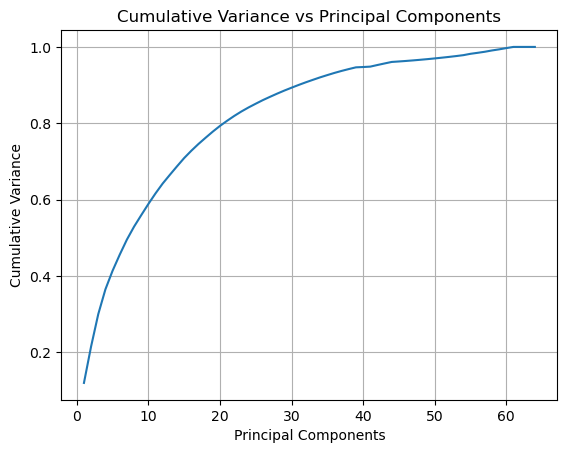

In [43]:
# Assuming pca.preserved_variances is a numpy array
components = list(range(1, pca.preserved_variances.shape[0] + 1))
plt.plot(components, pca.preserved_variances.tolist())
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Variance')
plt.title('Cumulative Variance vs Principal Components')
plt.grid(True)
plt.show()